# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [2]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [3]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

In [4]:
tu_data['credit_group'] = pd.qcut(tu_data.credit_score, 10, labels = False)
tu_data['loan_amnt_group'] = -1
for i in range(10): 
    tu_data.loc[(tu_data.credit_group == i).index,'loan_amnt_group'] = pd.qcut(tu_data.loc[(tu_data.credit_group == i).index,'loan_amnt'], 10, labels = False)

Output the first 5 rows of tu_data

In [5]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state,credit_group,loan_amnt_group
id,,,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI,9,2
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM,9,8
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD,2,1
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC,1,6
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN,1,4


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [6]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [7]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [8]:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [9]:
raleigh_df= pd.concat(map(pd.read_csv, raleigh_forms))
raleigh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13362 entries, 0 to 10
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13362 non-null  object 
 1   sequence_num           13362 non-null  object 
 2   requested_amount       13362 non-null  float64
 3   offered_interest_rate  13362 non-null  float64
 4   offer_accepted         13362 non-null  bool   
 5   offer_date             13362 non-null  object 
dtypes: bool(1), float64(2), object(3)
memory usage: 639.4+ KB


In [10]:
raleigh_df.offer_date = pd.to_datetime(raleigh_df.offer_date)
raleigh_df = raleigh_df.sort_values(by = ['offer_date'])
raleigh_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)

## How many rows are there in your table? How many distict ids?

In [11]:
print("Number of rows in the table:", raleigh_df.shape[0])
print("Number of distinct IDs:" , len(raleigh_df.id.value_counts()))

Number of rows in the table: 8792
Number of distinct IDs: 8792


How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

Answer: We don't have duplicates in the data cause we took the last offer given to each borrower. 
If we wouldn't drop the duplicate ids when laoded the data, we would have duplicated because borrowers negotiate their offeres, and coming back the next day to ask for a new offer. 


In [12]:
# duplicate_ids = raleigh_df.id.value_counts()[raleigh_df.id.value_counts()>1].index
# raleigh_df[raleigh_df.id.isin(duplicate_ids)].sample(n=5)

Drop all lines in the dataframe which contain irrelevant information.

In [13]:
#raleigh_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [14]:
print("The average interest rate offered to clients is ", raleigh_df.offered_interest_rate.mean())
print("The average interest rate among clients who accepted the offer is ", raleigh_df.loc[raleigh_df.offer_accepted == True].offered_interest_rate.mean())

The average interest rate offered to clients is  15.524284576888082
The average interest rate among clients who accepted the offer is  15.307480314960628


What is the percentage of activation in this dataframe?

In [15]:
print("The percentage of activation is ", raleigh_df.offer_accepted.mean())

The percentage of activation is  0.08666969972702457


Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [16]:
raleigh_df = raleigh_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])
raleigh_df

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state,credit_group,loan_amnt_group
0,743200d3e4cc1f6f860e121294248d611350f257a7bc83...,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01,652,36.0,17.69,3000.0,108.0,NC,2,0
1,9b785f1c83a022947857aa109de2aeb3c2c54231b910ed...,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,7000.0,17.98,False,2018-01-01,662,36.0,17.98,7000.0,253.0,NC,3,3
2,0f0b253809bb99eb4cd76ba8089f5746f2345ae3c59535...,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,3505.0,29.58,True,2018-01-01,623,36.0,29.58,3505.0,148.0,NC,1,1
3,e3e32f85cd78bb5002ccdc037c1818029f716e7a47911e...,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01,735,36.0,12.56,6899.0,231.0,NC,7,3
4,3a72ae7a82244f811b37c48f57469b708207004f011163...,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01,661,36.0,12.97,3800.0,128.0,NC,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8787,a2b763a8d324fd4bdd37ac7ad5bee9d62f936c52dd3c95...,77b3642dd8bc768d19a6b80466e5f7113e7372e1b1aa03...,17725.0,16.10,False,2020-12-10,618,60.0,16.10,17725.0,432.0,NC,1,7
8788,69b282258fdc0b55336a5c88e94dd0c0a4fdac7a6a448b...,8b1ed3ba66907feb4c208578846eddf03fc09c8a605048...,15000.0,15.27,False,2020-12-10,638,60.0,15.27,15000.0,359.0,NC,2,7
8789,46835ae976bb2c0790a1c283a74465be1b5a7cbd184198...,96be5e312cac0e00f7a0dc65d066f5da1de236336bd7c8...,10000.0,15.27,False,2020-12-10,694,36.0,15.27,10000.0,348.0,NC,5,5
8790,3aeb261118f66f05bd53de007f302a55da2554452f52f2...,b566fa6f6fba6c9afce55518c839f5126b7937b5abc7ff...,6174.0,6.91,False,2020-12-10,798,60.0,6.91,6174.0,122.0,NC,9,3


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [17]:
print("The average credit score of the clients is ", raleigh_df.credit_score.mean())
print("The average credit score of clients who accepted the offer is ", raleigh_df.loc[raleigh_df.offer_accepted == True].credit_score.mean())

The average credit score of the clients is  689.821542311192
The average credit score of clients who accepted the offer is  702.5446194225722


# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

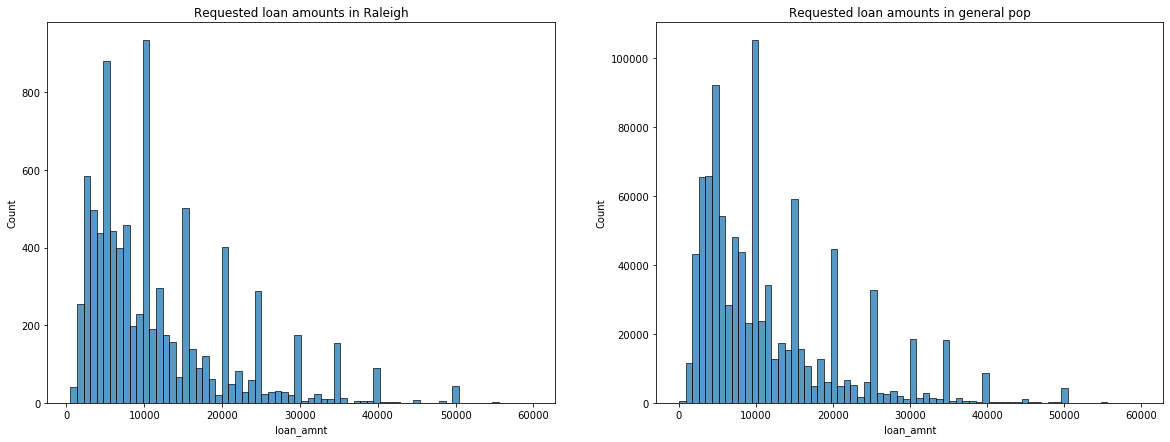

In [18]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 70)
plt.title("Requested loan amounts in Raleigh")
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 70)
plt.title("Requested loan amounts in general pop")
plt.show();

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

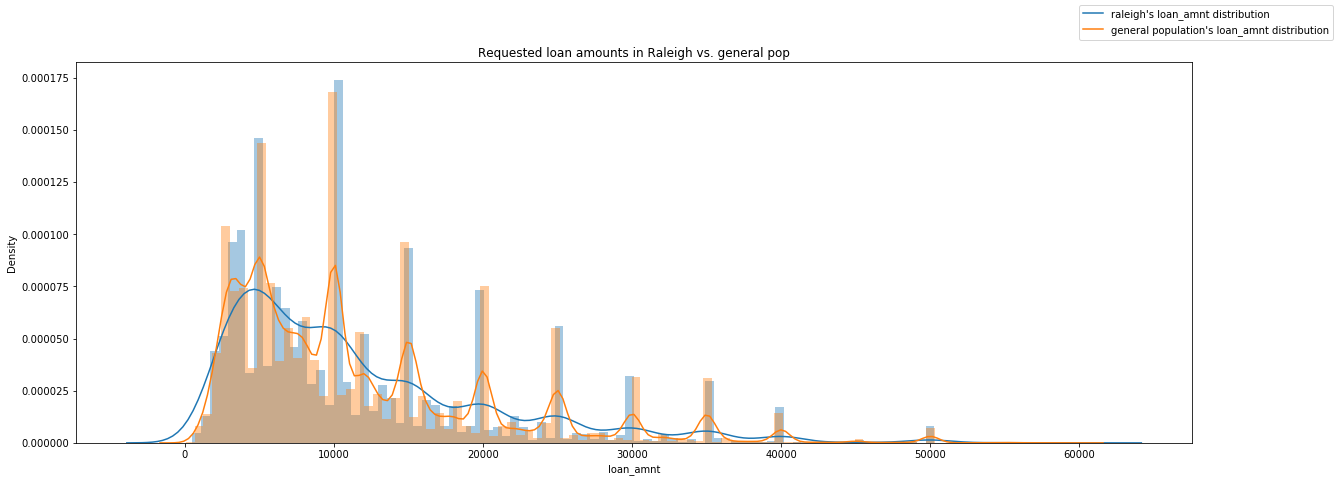

In [19]:
fig = plt.figure(figsize=(20,7))
#ax1 = plt.subplot(1, 2, 1)
sns.distplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 100)
#ax2 = plt.subplot(1, 2, 2)
sns.distplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 100)
fig.legend(labels=["raleigh's loan_amnt distribution","general population's loan_amnt distribution"])
plt.title("Requested loan amounts in Raleigh vs. general pop")
plt.show();

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

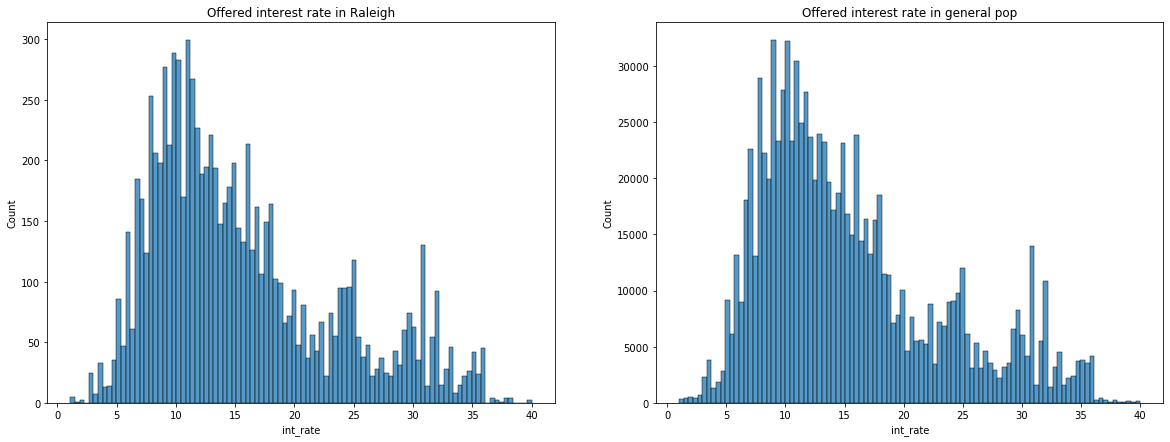

In [20]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.int_rate, bins = 100)
plt.title("Offered interest rate in Raleigh")
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.int_rate, bins = 100)
plt.title("Offered interest rate in general pop")
plt.show();

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

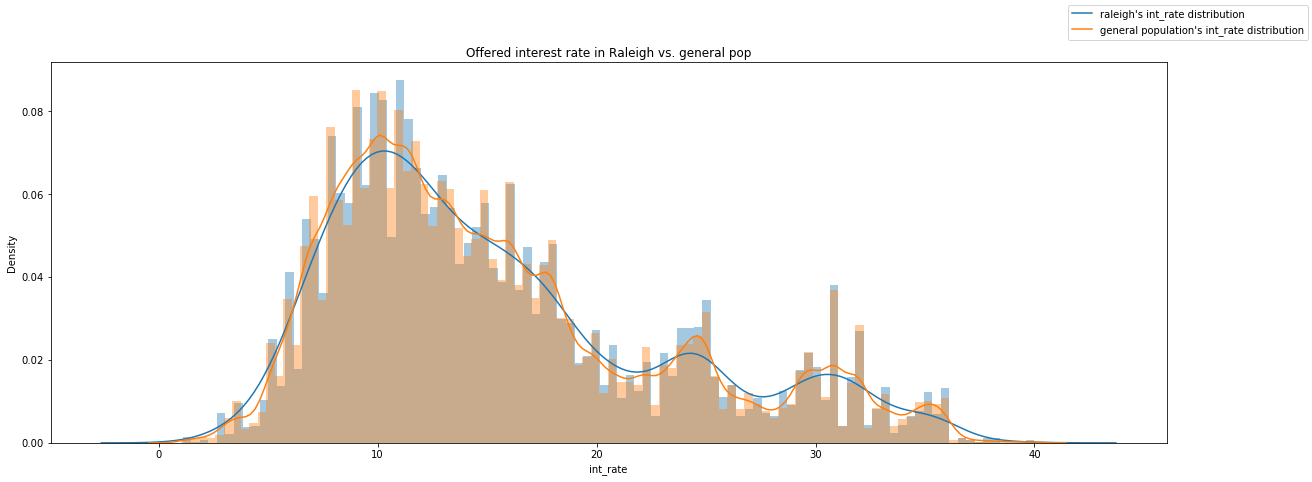

In [21]:
fig = plt.figure(figsize=(20,7))
sns.distplot(raleigh_df.int_rate, bins = 100)
sns.distplot(tu_data.int_rate, bins = 100)
plt.title("Offered interest rate in Raleigh vs. general pop")
fig.legend(labels=["raleigh's int_rate distribution","general population's int_rate distribution"])
plt.show();

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

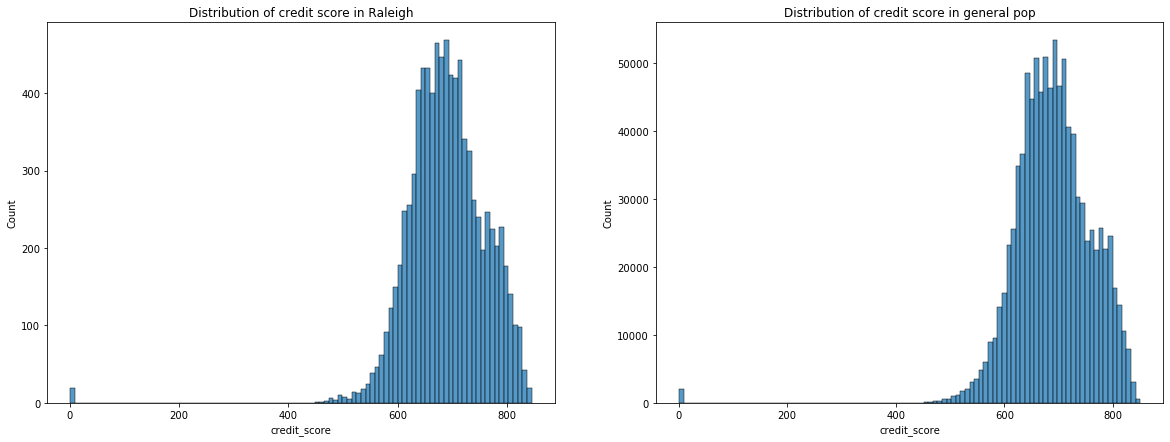

In [22]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.credit_score, bins = 100)
plt.title("Distribution of credit score in Raleigh")
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.credit_score, bins = 100)
plt.title("Distribution of credit score in general pop")
plt.show();

We see that we have observations with 0 credit score, which are outliers cause credit score range is [350,850]. lets delete these rows:

In [23]:
raleigh_df = raleigh_df.drop(raleigh_df[raleigh_df.credit_score < 350].index)
tu_data = tu_data.drop(tu_data[tu_data.credit_score < 350].index)

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

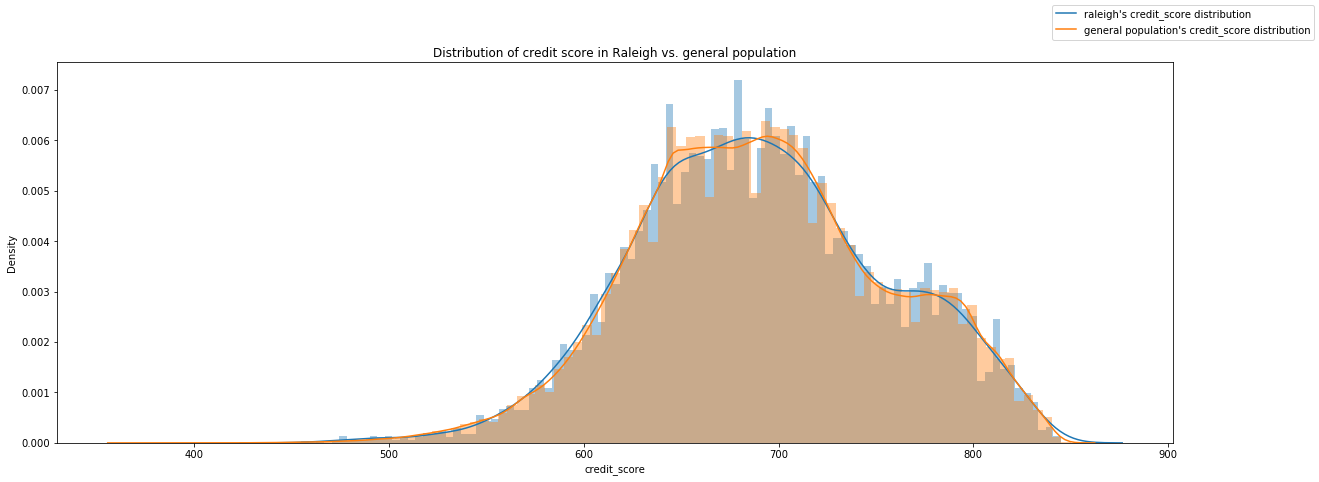

In [24]:
fig = plt.figure(figsize=(20,7))
sns.distplot(raleigh_df.credit_score, bins = 100)
sns.distplot(tu_data.credit_score, bins = 100)
plt.title("Distribution of credit score in Raleigh vs. general population")
fig.legend(labels=["raleigh's credit_score distribution","general population's credit_score distribution"])
plt.show();

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

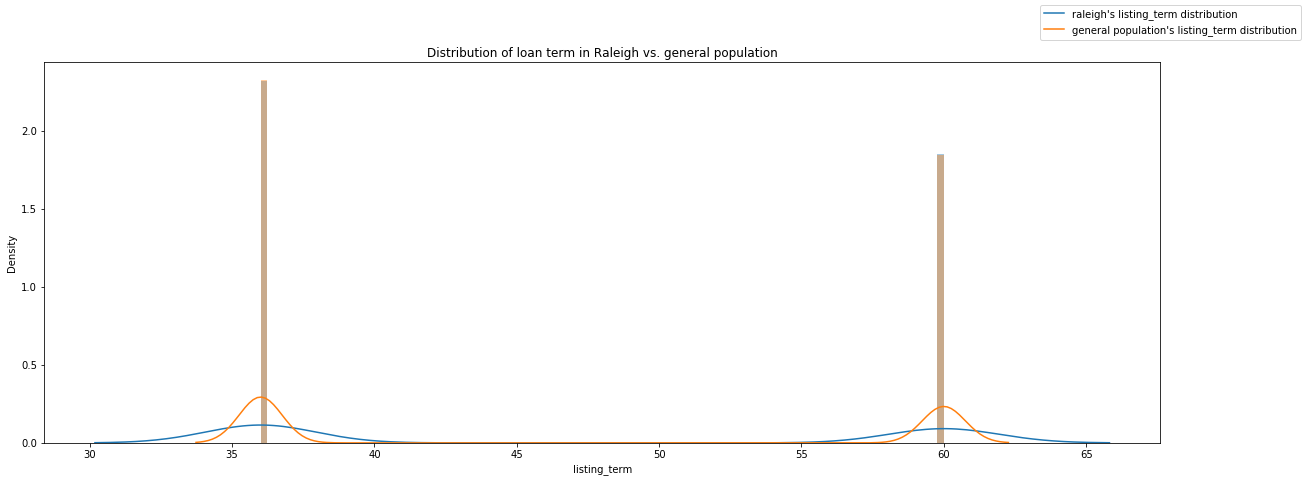

In [25]:
fig = plt.figure(figsize=(20,7))
sns.distplot(raleigh_df.listing_term, bins = 100)
sns.distplot(tu_data.listing_term, bins = 100)
plt.title("Distribution of loan term in Raleigh vs. general population")
fig.legend(labels=["raleigh's listing_term distribution","general population's listing_term distribution"])
plt.show();

We see that the distribution in all the parameters mentiond above is similar and the Raleig sample is not somehow distinct from the general population. <br>
For the listing term feature, we have two options, 36 month or 60 month. 

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

<b> Answer: </b>Activation has two optional values, True or False, therefore in can't have continuous distribution, it's an indicator which has a Bernuli distribution. 

The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [26]:
def CLT(s, n):
    m = int(len(s)/2)
    samples = s.sample(n*m, replace = True).to_numpy().reshape(n,m)
    samples_mean = samples.mean(axis = 0)
    return samples_mean

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [27]:
def plotHist(s, n):
    x = CLT(s, n)
    ax = sns.kdeplot(x, shade=False, color='crimson')
    kdeline = ax.lines[0]
    mean = x.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax.vlines(mean, 0, height, color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    plt.xlabel("Activation rate")
    return plt

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

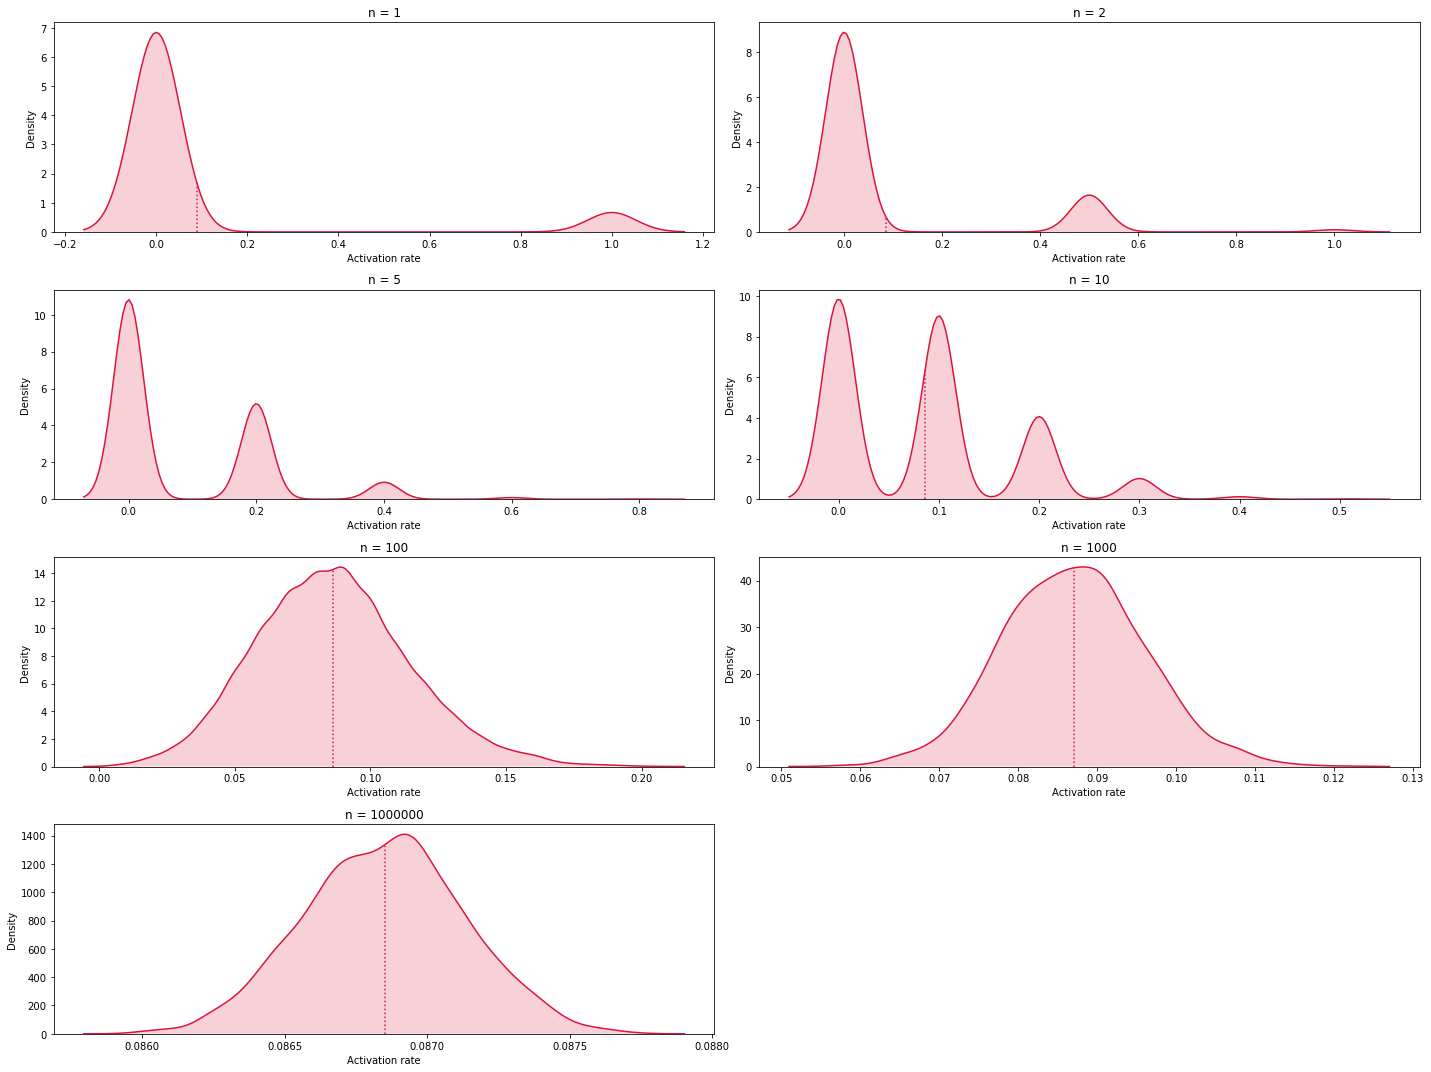

In [28]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 2, 5, 10, 100, 1000, 10**6]
for i in range(1, 8):
    plt.subplot(4, 2, i)
    plotHist(raleigh_df.offer_accepted, n_s[i-1])
    plt.title("n = "+str(n_s[i-1]))
plt.tight_layout()
plt.show();

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

In [29]:
!pip install statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [30]:
from statsmodels.stats.proportion import proportions_ztest

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?

<b>answer:</b>
$$ H_0 : p = 0.0685$$
$$ H_1 : p \neq 0.0685$$ 

2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?

<b>answer:</b>
* Type I error is alpha, and we set the confidenvce level to be 95% so 
$$ \alpha = 0.05 = P_{H_0} (reject H_0)$$ 
* The probability of type II error is 
$$ \beta = P_{H_1} (accept H_0) $$
* The power of the test is 
$$ \Pi = 1 - \beta = P_{H_1} (reject H_0) $$

Lets calculate them, we'll use the proportion of activation in the raleigh_df to estimate the mean and variance of H_1. 

In [31]:
n = raleigh_df.shape[0]
p0 = 0.0685
p1 = raleigh_df.offer_accepted.mean()
var0 = (p0*(1-p0))/n
var1 = (p1*(1-p1))/n
stat, pval = proportions_ztest(count = p1*n, nobs = n, value = p0, alternative = 'two-sided')
print("p_1 = ", p1, ", var_1 = ", var1)
critical = norm.pdf(0.95, loc = p0, scale = var0)
beta = norm.cdf(stat, loc = p1, scale = np.sqrt((p1*(1-p1))/n))
print("Beta = ", beta, ", Power =", 1-beta)

p_1 =  0.08685740339678559 , var_1 =  9.040601262048747e-06
Beta =  1.0 , Power = 0.0


3. Is the sample mean significantly different from the past value of 6.85?

In [32]:
print("The p-value  is ", pval, "which is smaller than 0.05 so we reject H0")

The p-value  is  1.0255733821903157e-09 which is smaller than 0.05 so we reject H0


4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?

We can declare the program as successful in increasing the activation, because we saw that the activation precentage increased and we got really small p-value so our result are very significant. 

5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

6. Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

What we know is that it isn't probable that the true activation rate in Raleigh is 6.85%. We can't be certain that the cause is the flyer program.

Other explanations might be that the activation rate in Raleigh is simply different than the rest of the population, regardless of the flyer program. Since we compared certain population characteristics (credit score, requested amount, offered rate, and loan term) and found them to be similar, they can't explain the difference.

But there could be other explanations like events that are specific to Raleigh, e.g., the city hosts a special event (the Olympic games???) and residents wanted loans because they counted on a mass of tourists generating income for them. Since we hadn't compared the time in which the loans were made, there could be a difference there which can explain the difference in activation.

In order to increase the confidence that the only explanation is the flyer program, we would need to run a randomized experiment where the groups (people who received the flyers vs. people who didn't) are totally random without any bias. As it is, there's a significant bias (people who received are from Raleigh, people who didn't are not; time periods may be different) that makes other explanations viable.

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [33]:
lubbock_forms = (glob.glob(os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")))
print(len(lubbock_forms))
lubbock_df= pd.concat(map(pd.read_csv, lubbock_forms))
lubbock_df.offer_date = pd.to_datetime(lubbock_df.offer_date)
lubbock_df = lubbock_df.sort_values(by = ['offer_date'])
lubbock_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)
lubbock_df = lubbock_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])
lubbock_df.head()

769


,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state,credit_group,loan_amnt_group
0,64796e2ad491e63b299894ddeabb5493e38b7b69770875...,5faf5b8cabb6636e1932f47b51c41e1b12324087fc2e27...,3258.0,17.58,False,2018-01-01,583.0,60.0,17.58,3258.0,82.0,TX,0.0,1.0
1,38d1be6da80ad94e7a2d226dbe070696c985613dd00f26...,e9d0ce908c56985675d71e793c06b5b6536afd3ba03d86...,16000.0,10.00,False,2018-01-01,692.0,60.0,10.00,16000.0,340.0,TX,5.0,7.0
2,c751b91bf7b5c2655d7ea397e5a03cbccb74513ff527e4...,f8b6f3cb44cfbb44ad3fa12e6758566a38ef13bbd822bd...,5000.0,18.09,True,2018-01-01,643.0,36.0,18.09,5000.0,181.0,TX,2.0,2.0
3,fb9780f1d54cf106cc5d371a7e2436e586759fb25c9bb6...,a7bf579d73703d66fe7481fe9b2d3c0061171ed87a718b...,3500.0,9.42,False,2018-01-01,698.0,36.0,9.42,3500.0,112.0,TX,5.0,1.0
4,13b8b97c37fc10f4ffb6801f95cc56c2abe64c702ecc7b...,05ff0b4b1c0454f00132c4b29feb87c91fe98f85ebbcf3...,10000.0,11.71,False,2018-01-01,758.0,60.0,11.71,10000.0,221.0,TX,8.0,5.0


What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [34]:
print("The average interest rate offered to clients is ", lubbock_df.offered_interest_rate.mean())
print("The average interest rate among clients who accepted the offer is ", lubbock_df.loc[lubbock_df.offer_accepted == True].offered_interest_rate.mean())

The average interest rate offered to clients is  15.505397526501767
The average interest rate among clients who accepted the offer is  13.553895131086144


What is the average credit score in Lubbock? What is it among accepting borrowers?

In [35]:
print("The average credit score of the clients is ", lubbock_df.credit_score.mean())
print("The average credit score of clients who accepted the offer is ", lubbock_df.loc[lubbock_df.offer_accepted == True].credit_score.mean())

The average credit score of the clients is  691.4914128895184
The average credit score of clients who accepted the offer is  730.5337078651686


What is the rate of activation in Lubbock?

In [36]:
print("The rate of activation is ", lubbock_df.offer_accepted.mean())

The rate of activation is  0.04717314487632509


## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

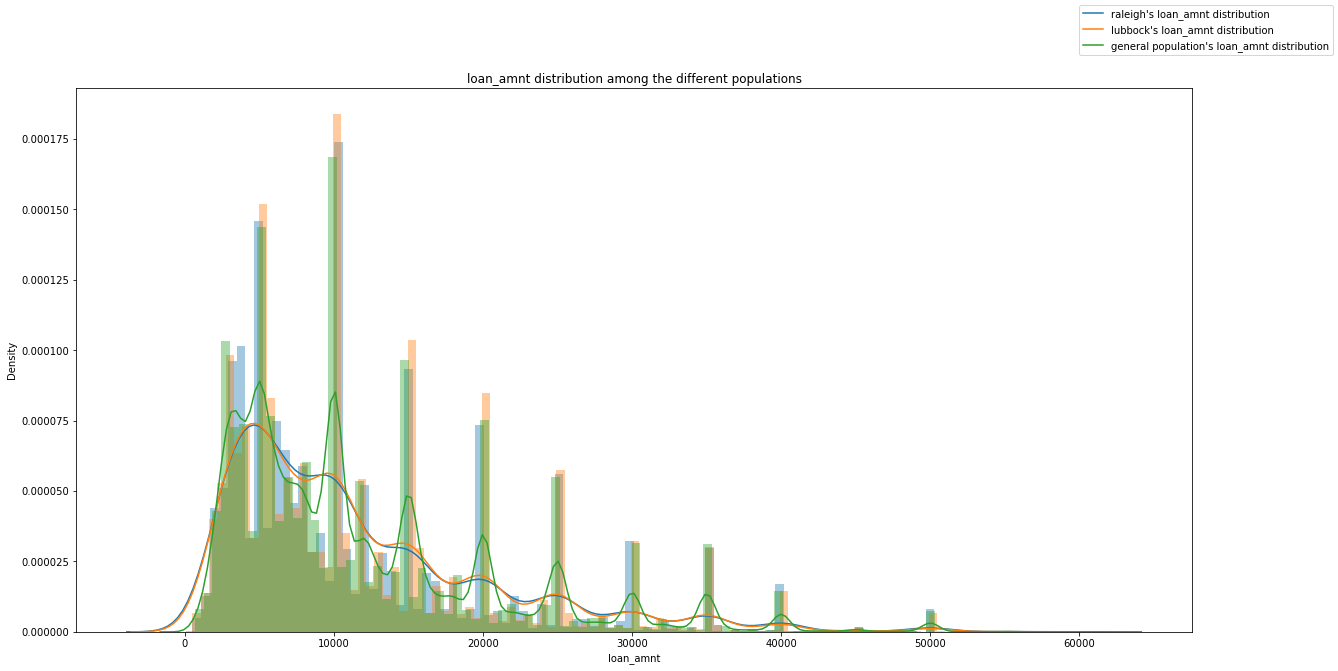

In [37]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 100)
sns.distplot(lubbock_df.loan_amnt[lubbock_df.loan_amnt<60000], bins = 100)
sns.distplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 100)

fig.legend(labels=["raleigh's loan_amnt distribution","lubbock's loan_amnt distribution", "general population's loan_amnt distribution"])
plt.title("loan_amnt distribution among the different populations")

plt.show();

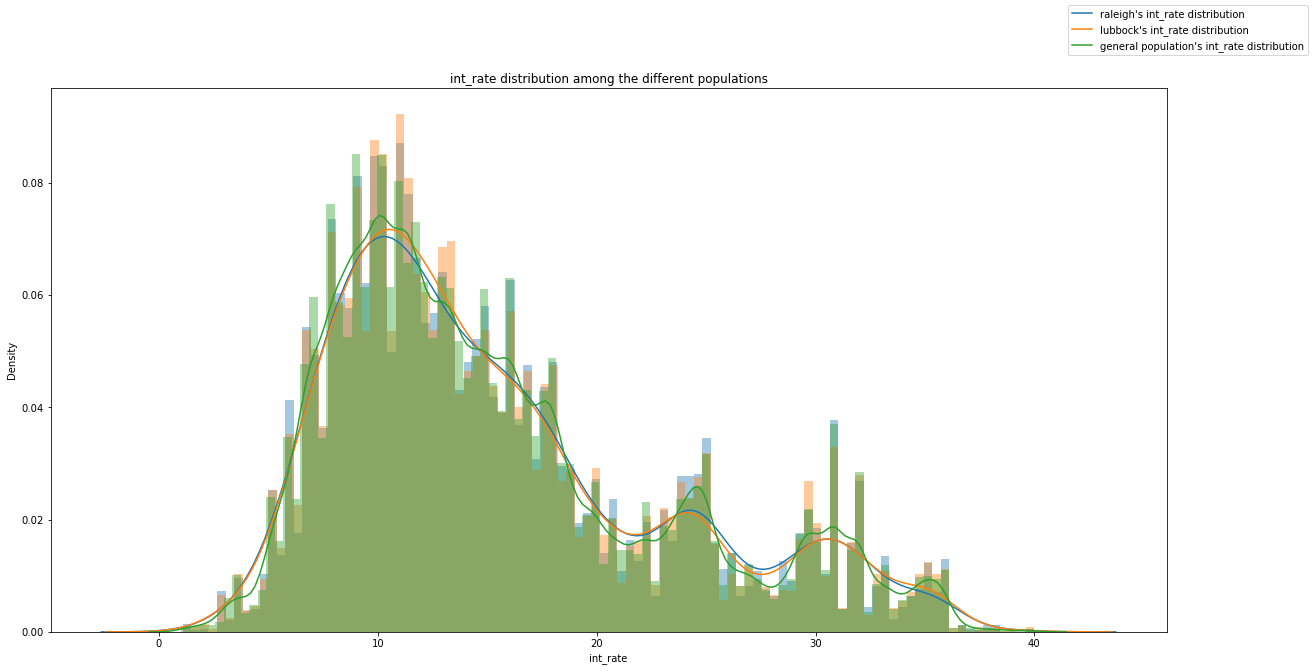

In [38]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.int_rate, bins = 100)
sns.distplot(lubbock_df.int_rate, bins = 100)
sns.distplot(tu_data.int_rate, bins = 100)

fig.legend(labels=["raleigh's int_rate distribution","lubbock's int_rate distribution","general population's int_rate distribution"])
plt.title("int_rate distribution among the different populations")
plt.show();

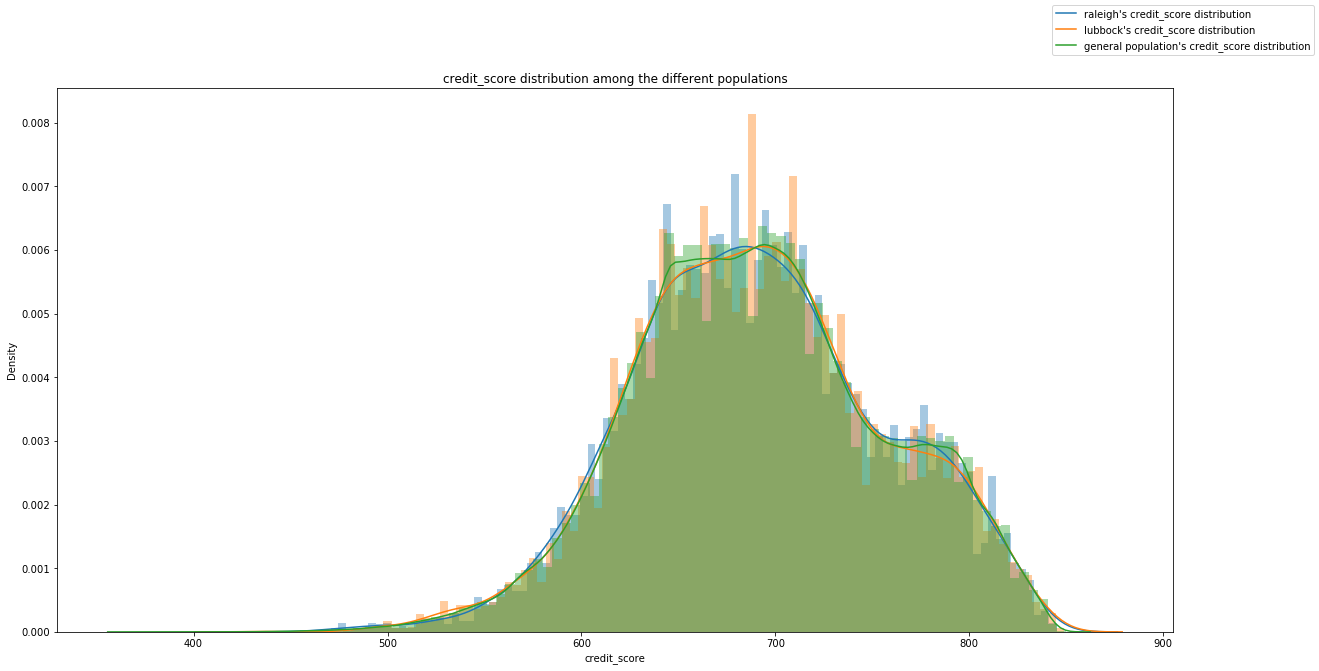

In [39]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.credit_score, bins = 100)
sns.distplot(lubbock_df.credit_score, bins = 100)
sns.distplot(tu_data.credit_score, bins = 100)

fig.legend(labels=["raleigh's credit_score distribution","lubbock's credit_score distribution","general population's credit_score distribution"])
plt.title("credit_score distribution among the different populations")
plt.show();

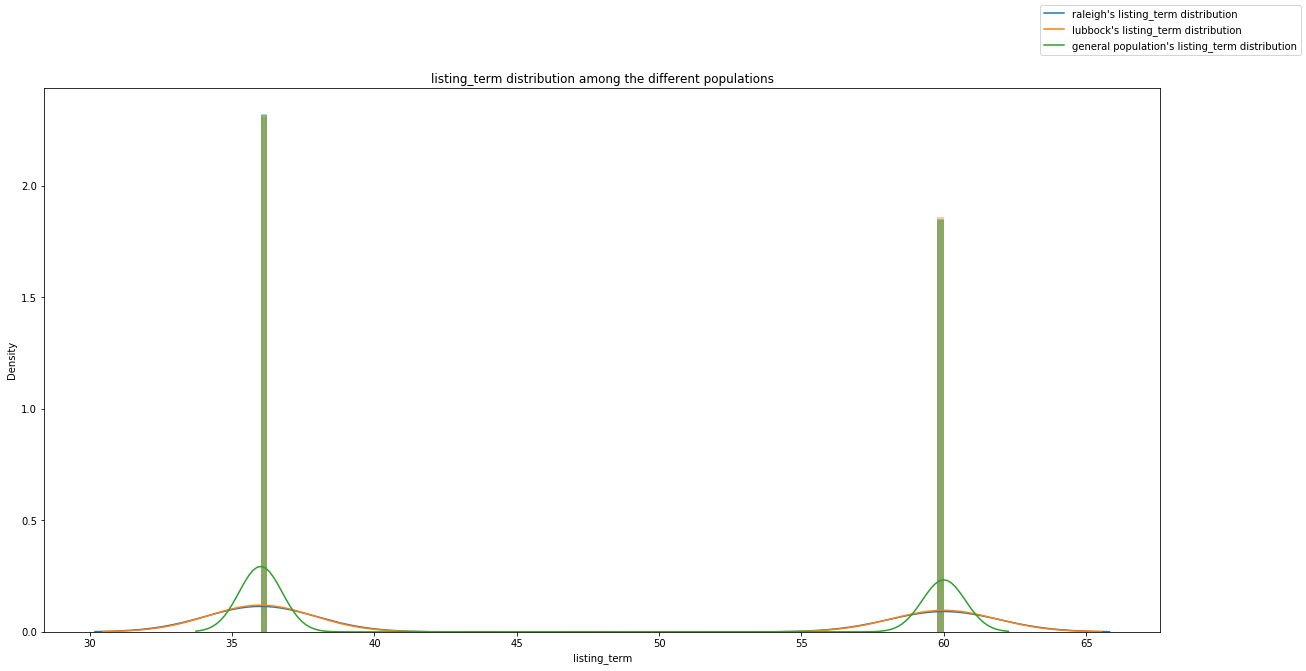

In [40]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.listing_term, bins = 100)
sns.distplot(lubbock_df.listing_term, bins = 100)
sns.distplot(tu_data.listing_term, bins = 100)

fig.legend(labels=["raleigh's listing_term distribution","lubbock's listing_term distribution","general population's listing_term distribution"])
plt.title("listing_term distribution among the different populations")
plt.show();

Looks like there's no main difference between the populations.

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

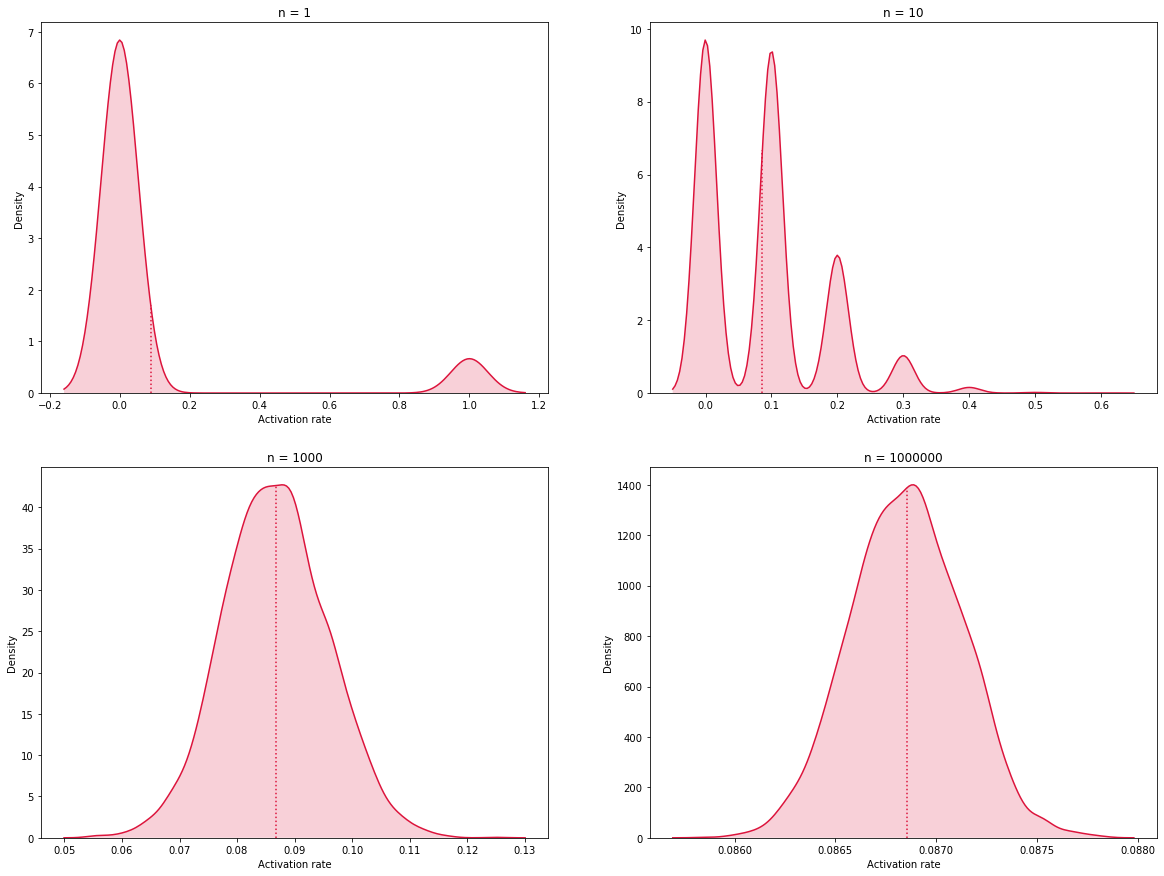

In [41]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 10, 1000, 10**6]
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plotHist(raleigh_df.offer_accepted, n_s[i-1])
    plt.title("n = "+str(n_s[i-1]))
plt.show();

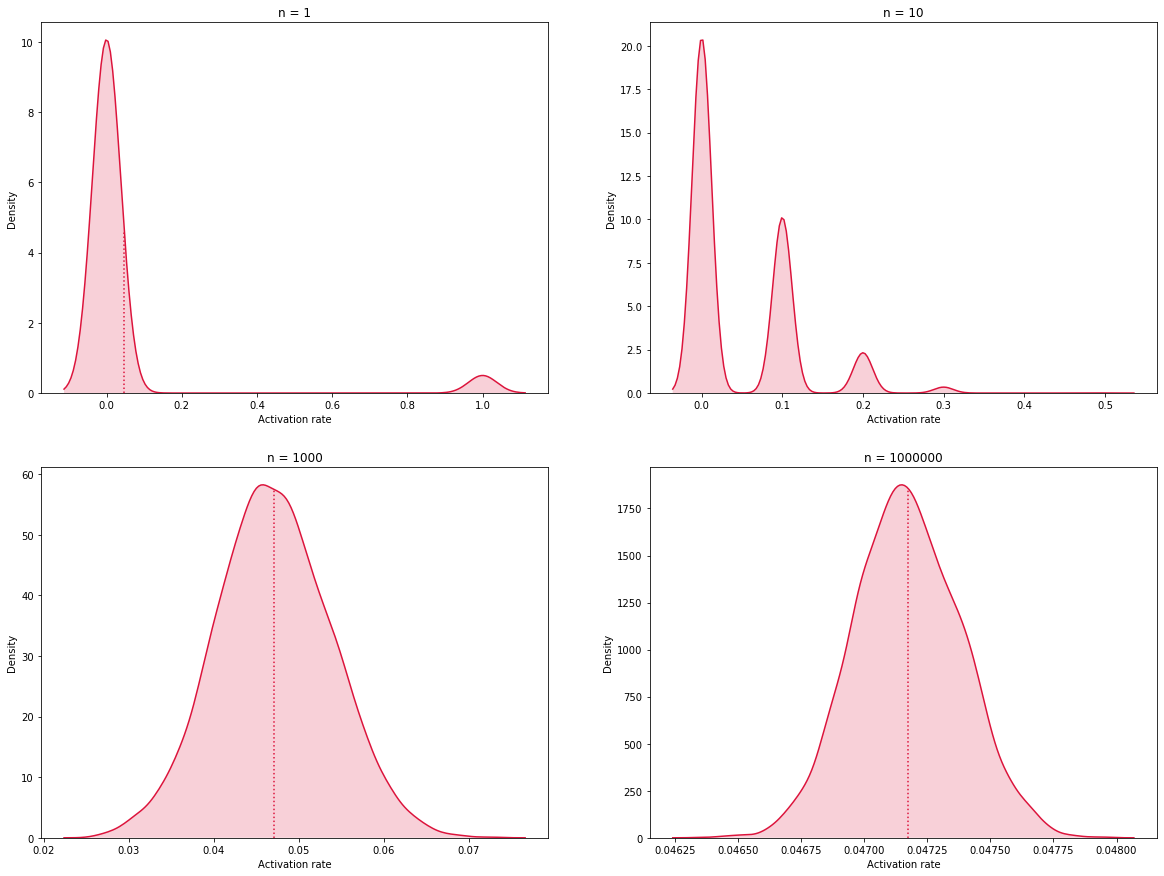

In [42]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 10, 1000, 10**6]
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plotHist(lubbock_df.offer_accepted, n_s[i-1])
    plt.title("n = "+str(n_s[i-1]))
plt.tight_layout()
plt.show();

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

(Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh). 



1. What are your hypotheses?

<b>answer:</b>
$$ H_0 : p_R = p_L$$
$$ H_1 : p_R \neq p_L$$ 

2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?

<b>answer:</b>
* Type I error is alpha, and we set the confidenvce level to be 95% so 
$$ \alpha = 0.05 = P_{H_0} (reject H_0)$$ 
* The probability of type II error is 
$$ \beta = P_{H_1} (accept H_0) $$
* The power of the test is 
$$ \Pi = 1 - \beta = P_{H_1} (reject H_0) $$

Lets calculate them:

In [43]:
p_R = raleigh_df.offer_accepted.mean()
p_L = lubbock_df.offer_accepted.mean()
counts = [raleigh_df.offer_accepted.sum(), lubbock_df.offer_accepted.sum()]
nobs = [raleigh_df.offer_accepted.count(), lubbock_df.offer_accepted.count()]
print(counts, nobs)
stat, pval = proportions_ztest(count = counts, nobs = nobs, alternative = 'two-sided')

[762, 534] [8773, 11320]


3. Are the two samples significantly different? 

In [44]:
print("The p-value  is", pval, ", so we reject H0.")

The p-value  is 6.789323954040955e-30 , so we reject H0.


4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

p-value is 1.7*10^-7, so this is the probability we got these results assuming H0. In other words, the results are very unlikely and therefore we reject H0. This means that we believe the activation rate is indeed different in Raleigh vs. Lubbock. As before, we can't be certain that this difference is due to the flyer program. Any bias introduced in the creation of the groups means there can be other explanations. The mst meaningful bias is the fact that the two gropus are from different cities. Any feature that is significantly different between the cities may explain this difference, not only the flyer program. However, we did eliminate many other biases so there aren't many features left that can reasonably explain the difference (we should still make sure Raleigh didn't host the Olympic games though...).

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

* We made it in the begining of the notebook to save code lines of merge dataframes. 


Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

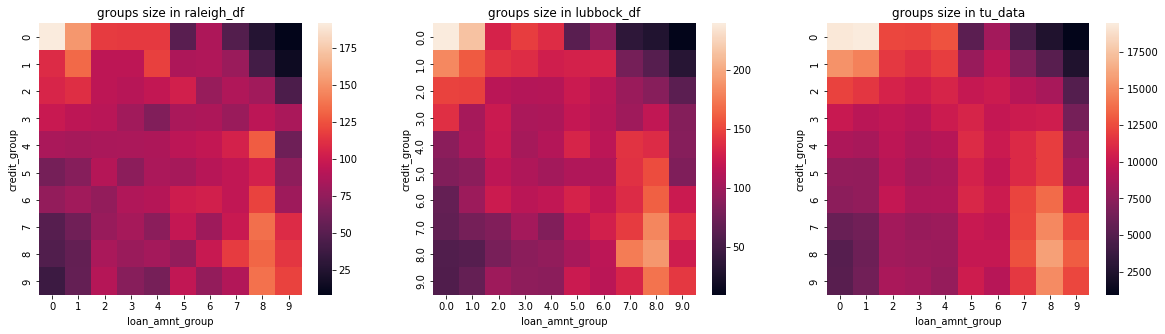

In [45]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.heatmap(raleigh_df.groupby(['credit_group', 'loan_amnt_group']).size().unstack())
plt.title("groups size in raleigh_df")
plt.subplot(1, 3, 2)
sns.heatmap(lubbock_df.groupby(['credit_group', 'loan_amnt_group']).size().unstack())
plt.title("groups size in lubbock_df")
plt.subplot(1, 3, 3)
sns.heatmap(tu_data.groupby(['credit_group', 'loan_amnt_group']).size().unstack())
plt.title("groups size in tu_data");

In [46]:
counts_R = raleigh_df.groupby(['credit_group', 'loan_amnt_group']).offer_accepted.sum()
nobs_R = raleigh_df.groupby(['credit_group', 'loan_amnt_group']).offer_accepted.count()
counts_L = lubbock_df.groupby(['credit_group', 'loan_amnt_group']).offer_accepted.sum()
nobs_L = lubbock_df.groupby(['credit_group', 'loan_amnt_group']).offer_accepted.count()

In [62]:
pvals = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        stat, pval = proportions_ztest(count = [counts_R.loc[i,j],counts_L.loc[i,j]], nobs = [nobs_R.loc[i,j], nobs_L.loc[i,j]], alternative = 'two-sided')
        pvals[i,j] = pval
pvals

array([[1.40309850e-06, 1.34711638e-03, 1.01778136e-01, 1.59595153e-04,
        7.28690313e-03, 6.55817982e-03, 6.02463541e-06, 1.21560128e-01,
        4.88960087e-01,            nan],
       [1.71704858e-02, 3.51500607e-01, 3.47256131e-01, 1.33830101e-02,
        3.47391117e-03, 1.87590394e-01, 3.52239672e-01, 5.26857187e-01,
        1.47505182e-01, 2.27799994e-01],
       [2.11359817e-01, 6.20183624e-02, 6.87607485e-01, 3.29732632e-01,
        5.29571024e-01, 1.86137723e-02, 3.57687813e-01, 1.65009446e-01,
        3.82564472e-02, 9.40243616e-02],
       [3.24713933e-01, 1.96293411e-01, 9.42214396e-02, 2.77960175e-02,
        7.13346422e-01, 3.49059411e-01, 2.80220215e-01, 2.90777547e-01,
        7.58789579e-01, 9.90556977e-01],
       [4.83262999e-01, 4.82590148e-01, 2.04284199e-01, 1.23811664e-01,
        1.35697409e-01, 3.01505855e-02, 8.98053610e-01, 4.26351898e-01,
        6.99580128e-01, 3.57352937e-01],
       [1.74511870e-03, 9.68923274e-02, 1.69339184e-02, 6.49759832e-02,
   

In [154]:
(np.nan_to_num(pvals, nan=1)<0.05).sum()

19

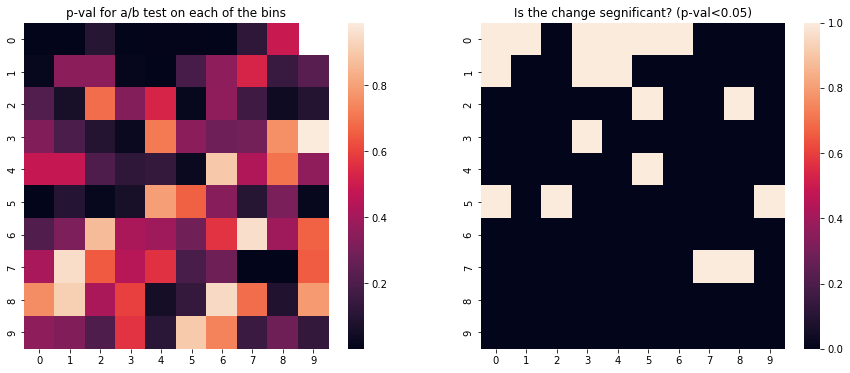

In [66]:
fig = plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.heatmap(pvals)
plt.title("p-val for a/b test on each of the bins")
plt.subplot(1, 2, 2)
sig_05_pvals = np.nan_to_num(pvals, nan=1)<0.05
sns.heatmap(sig_05_pvals)
plt.title("Is the change segnificant? (p-val<0.05)")
plt.show();

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

For each test, the probability rejecting the null hypothesis is 0.05, as defined in each test, but if multiple hypotheses are tested, the chance of observing a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases. 

## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

In [67]:
sig_05_Bonferroni = np.nan_to_num(pvals, nan=1)<0.0005
sig_05_Bonferroni

array([[ True, False, False,  True, False, False,  True, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

How many of your tests came out significant under this correction?

In [68]:
sig_05_Bonferroni.sum()

3

We have 3 test who came out significant under this correction. 

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

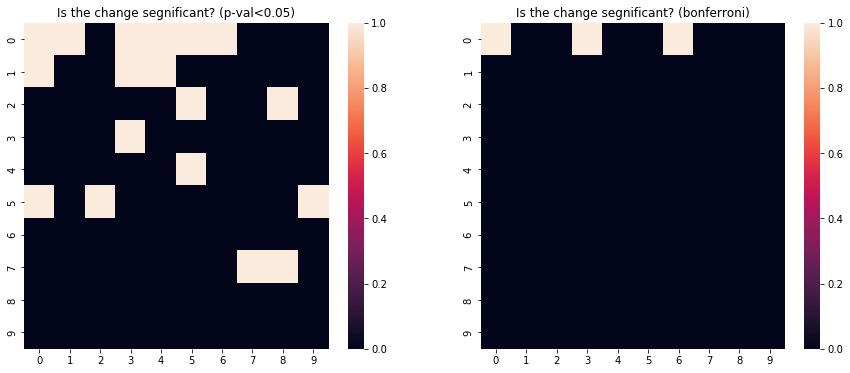

In [136]:
fig = plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.heatmap(sig_05_pvals)
plt.title("Is the change segnificant? (p-val<0.05)")
plt.subplot(1, 2, 2)
sns.heatmap(sig_05_Bonferroni)
plt.title("Is the change segnificant? (bonferroni)")
plt.show();

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [124]:
pvals_df=pd.DataFrame(data=pvals.flatten(),columns=['p_val']).fillna(1)
pvals_df.sort_values(by='p_val', ascending = True, inplace = True)
pvals_df.reset_index(inplace=True)
pvals_df

,index,p_val
0,0,0.000001
1,6,0.000006
2,3,0.000160
3,1,0.001347
4,78,0.001410
...,...,...
95,86,0.940302
96,71,0.955159
97,67,0.958553
98,39,0.990557


Plot your sorted $p$-values

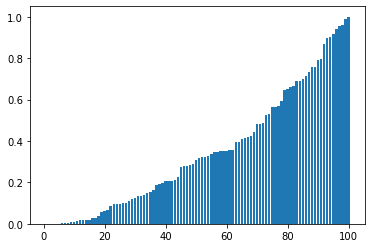

In [125]:
plt.bar(x=np.arange(1,101),height=pvals_df['p_val']);

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

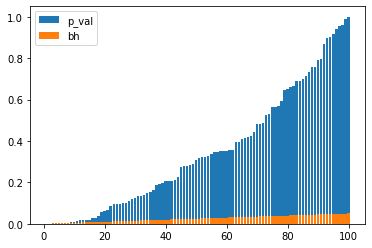

In [127]:
pvals_df['bh'] = [(i/100)*0.05 for i in range(1,101)]
plt.bar(x=np.arange(1,101),height=pvals_df['p_val'])
plt.bar(x=np.arange(1,101),height=pvals_df['bh'])
plt.legend(labels=['p_val','bh'])
plt.show();

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

In [128]:
pvals_df['test']=pvals_df.p_val<pvals_df.bh
pvals_df

,index,p_val,bh,test
0,0,0.000001,0.0005,True
1,6,0.000006,0.0010,True
2,3,0.000160,0.0015,True
3,1,0.001347,0.0020,True
4,78,0.001410,0.0025,True
...,...,...,...,...
95,86,0.940302,0.0480,False
96,71,0.955159,0.0485,False
97,67,0.958553,0.0490,False
98,39,0.990557,0.0495,False


In [129]:
max_id=pvals_df.loc[pvals_df.test==True,'p_val'].argmax()
max_id

7

Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [130]:
pvals_bh=np.array(pvals_df.sort_values(by='index').test).reshape(10,10)

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

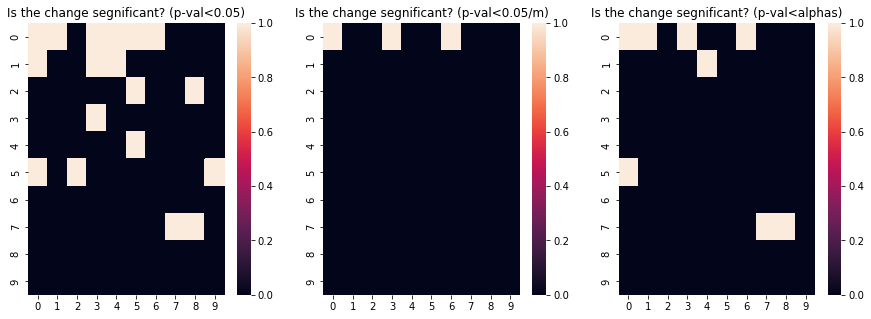

In [135]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.heatmap(sig_05_pvals)
plt.title("Is the change segnificant? (p-val<0.05)")
plt.subplot(1, 3, 2)
sns.heatmap(sig_05_Bonferroni)
plt.title("Is the change segnificant? (bonferroni)")
plt.subplot(1, 3, 3)
sns.heatmap(pvals_bh)
plt.title("Is the change segnificant? (bh)")
plt.show();

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.

In [137]:
from statsmodels.stats.multitest import multipletests

In [151]:
bonferroni_results = multipletests(np.nan_to_num(pvals,-1).flatten(), alpha=0.05, method='bonferroni', returnsorted=False)
fdr_bh_results = multipletests(np.nan_to_num(pvals,-1).flatten(), alpha=0.05, method='fdr_bh', returnsorted=False)

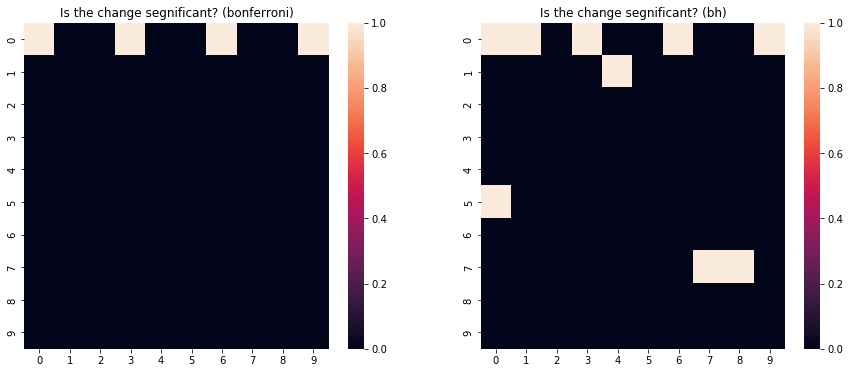

In [152]:
fig = plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.heatmap((bonferroni_results[0]).reshape(10,10))
plt.title("Is the change segnificant? (bonferroni)")
plt.subplot(1, 2, 2)
sns.heatmap((fdr_bh_results[0]).reshape(10,10))
plt.title("Is the change segnificant? (bh)")
plt.show();

Except for the last group in the first row (which is empty), the plots are exactly the same.